# Import thư viện

In [ ]:
# Nhập các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as pltaaaa
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from datetime import datetime, timedelta
from google.colab import drive
import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Gắn Google Drive để truy cập dữ liệu
drive.mount('/gdrive')
# Đọc dữ liệu
df = pd.read_csv('/gdrive/MyDrive/CDTN2/Samsung.csv')
df

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Date     Open     High      Low    Close     Adj Close    Volume
0     2000-01-04   6000.0   6110.0   5660.0   6110.0   4449.709961  74195000
1     2000-01-05   5800.0   6060.0   5520.0   5580.0   4063.728760  74680000
2     2000-01-06   5750.0   5780.0   5580.0   5620.0   4092.859863  54390000
3     2000-01-07   5560.0   5670.0   5360.0   5540.0   4034.598877  40305000
4     2000-01-10   5600.0   5770.0   5580.0   5770.0   4202.098145  46880000
...          ...      ...      ...      ...      ...           ...       ...
6122  2024-06-07  78400.0  78600.0  77100.0  77300.0  77300.000000  21189349
6123  2024-06-10  76100.0  76600.0  75600.0  75700.0  75700.000000  14598755
6124  2024-06-11  75900.0  76000.0  75100.0  75200.0  75200.000000  16971175
6125  2024-06-12  75300.0  77100.0  75200.0  76500.0  76500.000000  19246725
6126  2024-06-13  78400.0  79000.0  77800.0  78600.0  78600.000000  33763804

[6127 rows x 7 columns]

In [ ]:
# Hiển thị thông tin của dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6127 non-null   object 
 1   Open       6127 non-null   float64
 2   High       6127 non-null   float64
 3   Low        6127 non-null   float64
 4   Close      6127 non-null   float64
 5   Adj Close  6127 non-null   float64
 6   Volume     6127 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 335.2+ KB


In [ ]:
# Chuyển đổi cột 'Date' sang kiểu datetime và sắp xếp theo ngày
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
#Kiểm tra lại kết quả
df.head()

In [ ]:
# Kiểm tra giá trị trùng lặp và thiếu
print("Giá trị trùng lặp:", df.duplicated().sum())
print("Giá trị thiếu:", df.isnull().sum().sum())

Giá trị trùng lặp: 0
Giá trị thiếu: 0


In [ ]:
# Trực quan hóa giá đóng cửa theo thời gian
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="Giá Đóng Cửa",
                  title={'text': "Lịch sử giá Samsung", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')
fig.show()

# Mô hình LSTM

In [ ]:
# Xác định kích thước của tập kiểm tra dựa trên dữ liệu năm 2024
test_size = df[df.Date.dt.year == 2024].shape[0]
print("Kích thước tập kiểm tra:", test_size)

Kích thước tập kiểm tra: 110


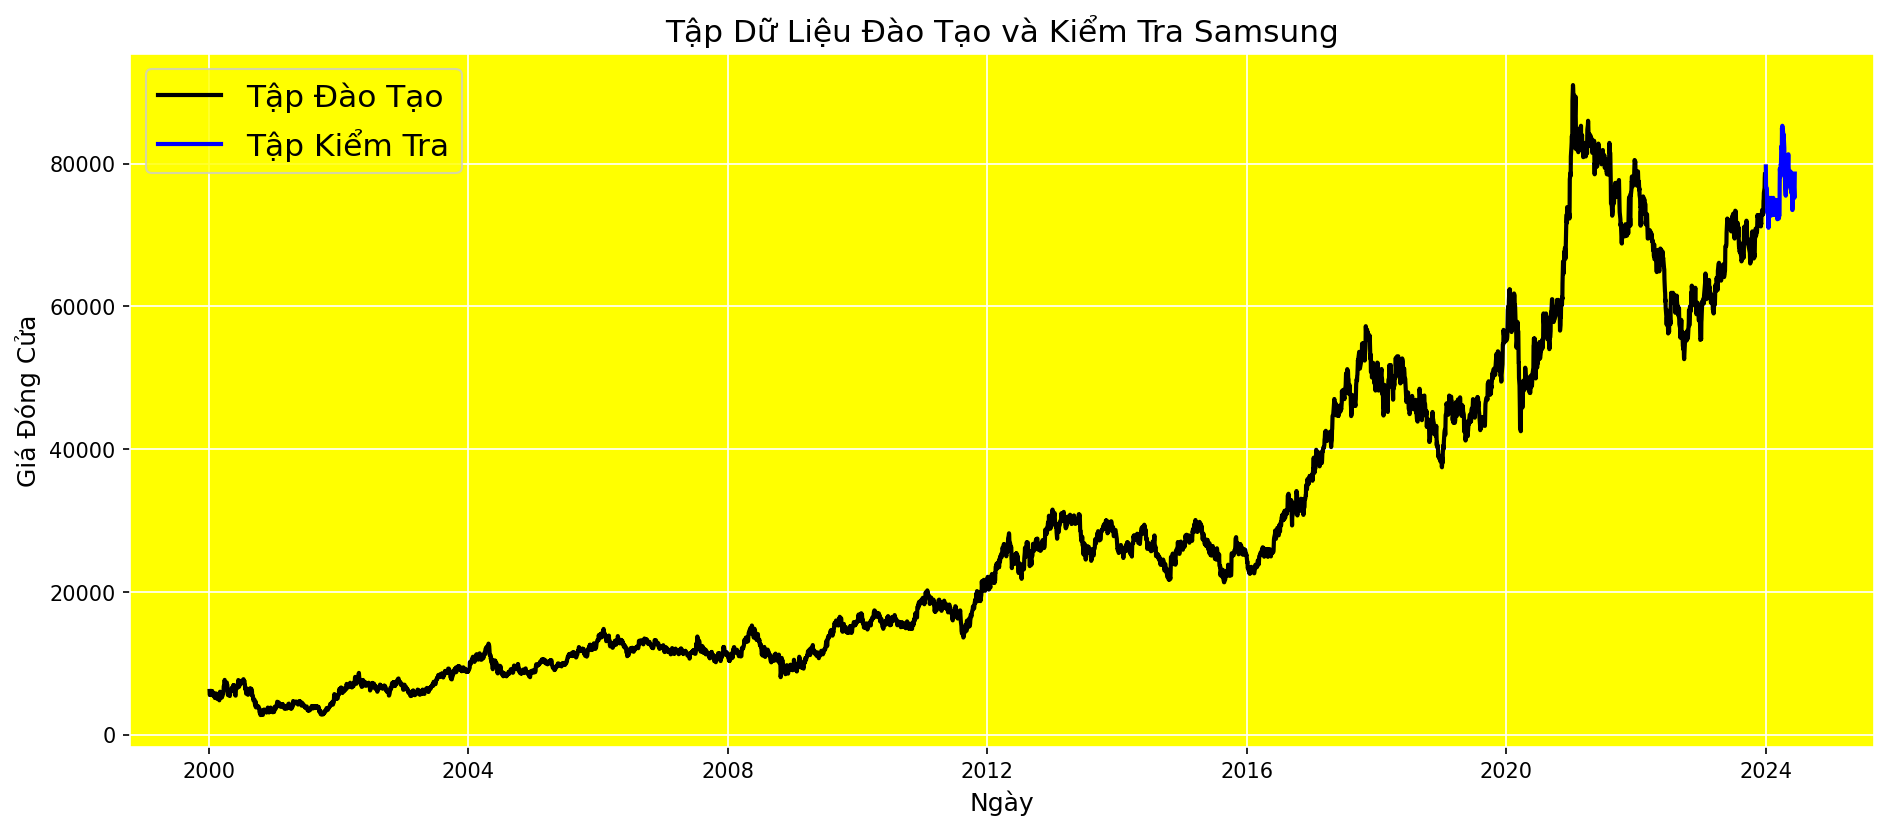

In [ ]:
# Vẽ tập dữ liệu đào tạo và kiểm tra
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='black', lw=2, label='Tập Đào Tạo')
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='blue', lw=2, label='Tập Kiểm Tra')
plt.title('Tập Dữ Liệu Đào Tạo và Kiểm Tra Samsung', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Đóng Cửa', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [ ]:
# Chuẩn bị dữ liệu cho việc huấn luyện
closing_prices = df['Close'].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

look_back = 60
train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))

In [ ]:
# Tạo dữ liệu huấn luyện
X_train = []
y_train = []

for i in range(look_back, len(train_data)):
    X_train.append(train_data[i - look_back:i, 0])
    y_train.append(train_data[i, 0])

test_data = df.Close[-test_size - look_back:]
test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Tạo dữ liệu kiểm tra
X_test = []
y_test = []

for i in range(look_back, len(test_data)):
    X_test.append(test_data[i - look_back:i, 0])
    y_test.append(test_data[i, 0])

In [ ]:
# Chuyển đổi thành mảng numpy và reshape cho LSTM
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('Kích thước X_train:', X_train.shape)
print('Kích thước y_train:', y_train.shape)
print('Kích thước X_test:', X_test.shape)
print('Kích thước y_test:', y_test.shape)

Kích thước X_train: (5957, 60, 1)
Kích thước y_train: (5957,)
Kích thước X_test: (110, 60, 1)
Kích thước y_test: (110,)


In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Huấn luyện mô hình với early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stop])

Epoch 1/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 0.0079 - val_loss: 5.6289e-04
Epoch 2/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 1.9505e-04 - val_loss: 5.1061e-04
Epoch 3/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 1.8067e-04 - val_loss: 8.2745e-04
Epoch 4/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 1.7471e-04 - val_loss: 7.0940e-04
Epoch 5/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 1.3689e-04 - val_loss: 6.1278e-04
Epoch 6/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 1.7692e-04 - val_loss: 3.8925e-04
Epoch 7/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 1.4115e-04 - val_loss: 3.2096e-04
Epoch 8/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.2629e-04 - val_loss: 3.0139e-04
Epoch 9/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 1.1447e-04 - val_loss: 3.3632e-04
Epoch 10/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 1.3652e-04 - val_loss: 9.9352e-04
Epoch 11/150
168/168 ━━━━━━━━━━━━━━━━

In [ ]:
# Đánh giá mô hình
test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.1414e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


In [ ]:
# Tính MAPE và độ chính xác
MAPE = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 1 - MAPE
print("Test Loss:", test_loss)
print("Test MAPE:", MAPE)
print(f'Độ chính xác: {accuracy*100:.5f}%')

Test Loss: 0.00023381781647913158
Test MAPE: 0.01369961499481924
Độ chính xác: 98.63004%


In [ ]:
# Vẽ biểu đồ Loss trong quá trình huấn luyện
plt.rcParams['axes.facecolor'] = 'White'
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Số Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Quá trình Huấn Luyện và Validation Loss')
plt.show()

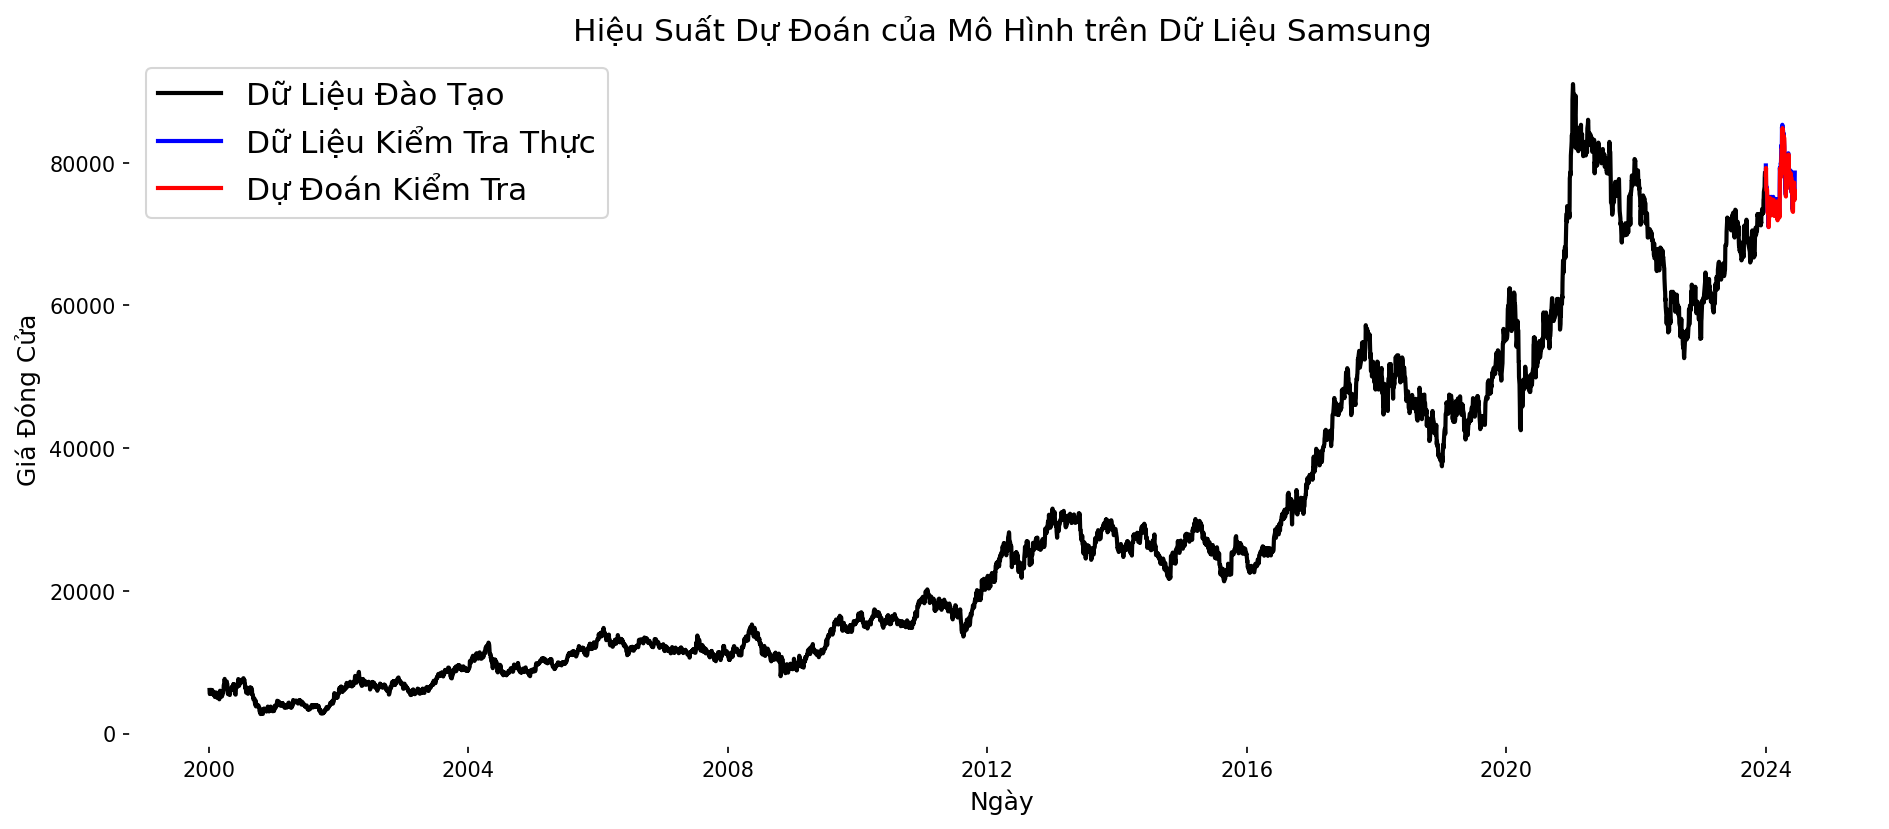

In [ ]:
# Biến đổi lại giá trị dự đoán và giá trị thực tế của tập kiểm tra để so sánh
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred)

# Vẽ biểu đồ hiệu suất dự đoán của mô hình trên tập kiểm tra
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2, label='Dữ Liệu Đào Tạo')
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2, label='Dữ Liệu Kiểm Tra Thực')
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2, label='Dự Đoán Kiểm Tra')
plt.title('Hiệu Suất Dự Đoán của Mô Hình trên Dữ Liệu Samsung', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Đóng Cửa', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Mô hình Simple RNN

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping

window_size = 60

def define_model():
    input1 = Input(shape=(window_size,1))
    x = SimpleRNN(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = SimpleRNN(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = SimpleRNN(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer=Nadam())
    model.summary()

    return model

In [ ]:
model_RNN = define_model()
# Huấn luyện mô hình với EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_RNN.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stop])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 60, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,849 (89.25 KB)

 Trainable params: 22,849 (89.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0882 - val_loss: 0.0105
Epoch 2/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 3/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0030 - val_loss: 8.8827e-04
Epoch 4/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0021 - val_loss: 6.1829e-04
Epoch 6/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0016 - val_loss: 4.7553e-04
Epoch 7/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0015 - val_loss: 7.1272e-04
Epoch 8/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0014 - val_loss: 7.1349e-04
Epoch 9/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0013 - val_loss: 4.6754e-04
Epoch 10/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0011 - val_loss: 6.7520

In [ ]:
result_RNN = model_RNN.evaluate(X_test, y_test)
y_pred_RNN = model_RNN.predict(X_test)

MAPE_RNN = mean_absolute_percentage_error(y_test, y_pred_RNN)
Accuracy_RNN = 1 - MAPE_RNN

print("Test Loss:", result_RNN)
print("Test MAPE:", MAPE_RNN)
print(f'Độ chính xác: {Accuracy_RNN*100:.5f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.7926e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
Test Loss: 0.0010120273800566792
Test MAPE: 0.026396202428313732
Độ chính xác: 97.36038%


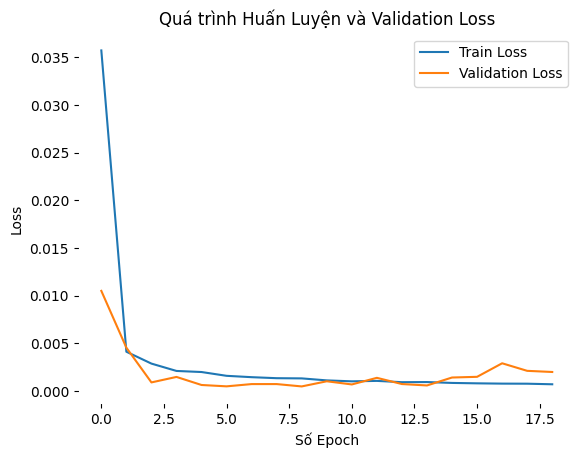

In [ ]:
# Vẽ biểu đồ Loss trong quá trình huấn luyện
plt.rcParams['axes.facecolor'] = 'White'
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Số Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Quá trình Huấn Luyện và Validation Loss')
plt.show()

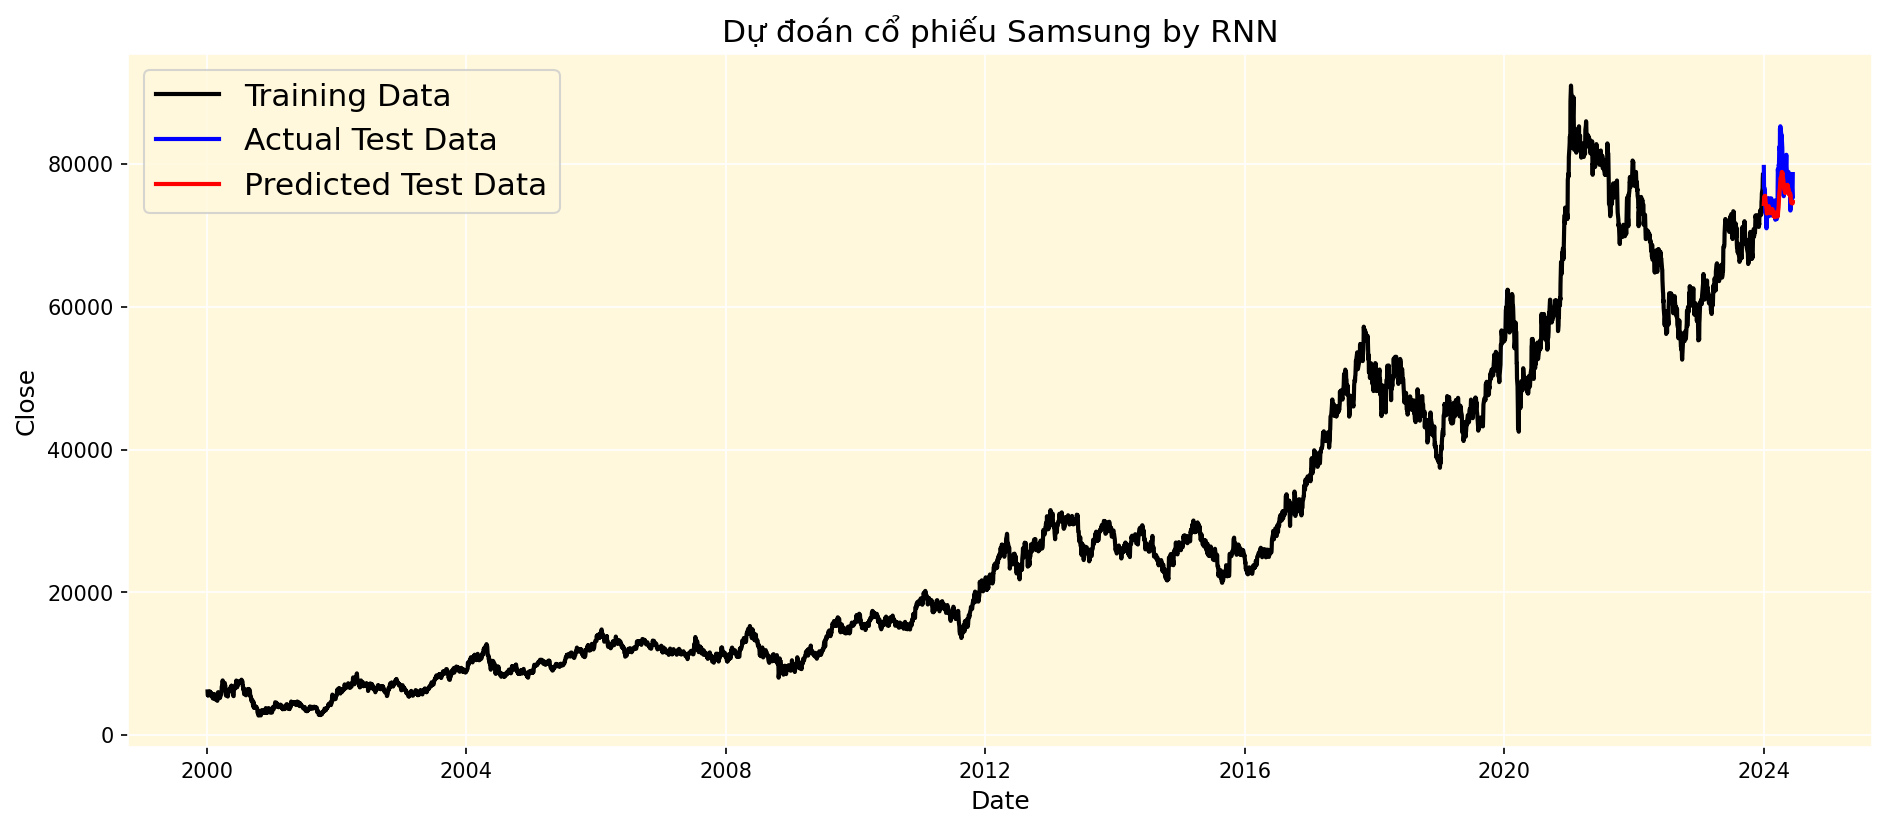

In [ ]:
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred_RNN)

# Xem mức độ chính xác mô hình dự đoán với thực tế:__

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'Cornsilk'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Dự đoán cổ phiếu Samsung by RNN', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Mô hình CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Xây dựng mô hình CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# Biên dịch mô hình
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Huấn luyện mô hình CNN
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_cnn.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stop])

Epoch 1/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 2/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6384e-04 - val_loss: 0.0020
Epoch 3/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4977e-04 - val_loss: 5.5005e-04
Epoch 4/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1031e-04 - val_loss: 0.0015
Epoch 5/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2091e-04 - val_loss: 4.3102e-04
Epoch 6/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6115e-04 - val_loss: 4.7418e-04
Epoch 7/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5790e-04 - val_loss: 5.3814e-04
Epoch 8/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7060e-04 - val_loss: 4.2294e-04
Epoch 9/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7480e-04 - val_loss: 6.0958e-04
Epoch 10/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.6708e-04 - val_loss: 0.0021
Epoch 11/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0378e

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
result_cnn = model_cnn.evaluate(X_test, y_test)
y_pred_cnn = model_cnn.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5886e-04 


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
# Tính MAPE và độ chính xác
MAPE_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)
Accuracy_cnn = 1 - MAPE_cnn

In [ ]:
# In kết quả
print("Test Loss:", result_cnn)
print("Test MAPE:", MAPE_cnn)
print(f'Độ chính xác: {Accuracy_cnn*100:.5f}%')

Test Loss: 0.0004983214312233031
Test MAPE: 0.02086850985281702
Độ chính xác: 97.91315%


In [ ]:
# Vẽ biểu đồ Loss trong quá trình huấn luyện
plt.rcParams['axes.facecolor'] = 'White'
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Số Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Quá trình Huấn Luyện và Validation Loss')
plt.show()

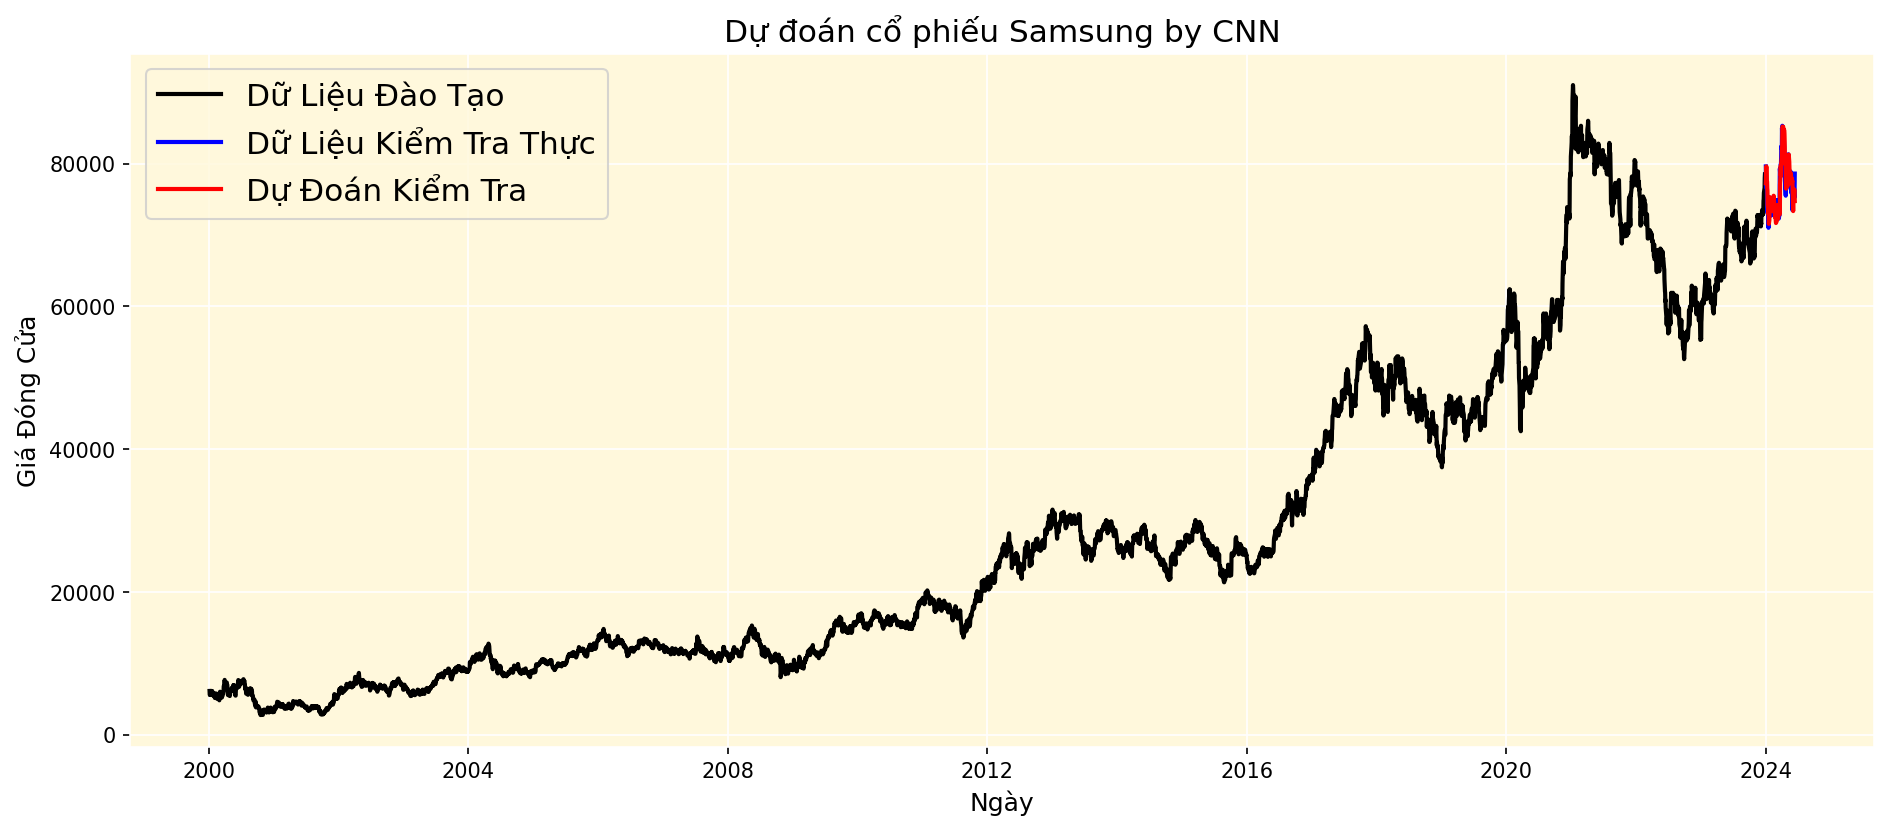

In [ ]:
# Chuyển đổi dự đoán về giá trị thực tế
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred_cnn.reshape(-1, 1))

# Vẽ biểu đồ so sánh dữ liệu thực tế và dự đoán
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'Cornsilk'
plt.rc('axes', edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(scaled_data[:-test_size]), color='black', lw=2, label='Dữ Liệu Đào Tạo')
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2, label='Dữ Liệu Kiểm Tra Thực')
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2, label='Dự Đoán Kiểm Tra')
plt.title('Dự đoán cổ phiếu Samsung by CNN', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Đóng Cửa', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Kết quả

LSTM
* Test Loss: 0.00023381781647913158
* Test MAPE: 0.01369961499481924
* Độ chính xác: 98.63004%

Simple RNN
* Test Loss: 0.0010120273800566792
* Test MAPE: 0.026396202428313732
* Độ chính xác: 97.36038%

CNN
* Test Loss: 0.0004983214312233031
* Test MAPE: 0.02086850985281702
* Độ chính xác: 97.91315%